In [1]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import controller
import torch 

In [2]:
class NN(torch.nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.L1 = torch.nn.Linear(1,30)
        self.L2 = torch.nn.Linear(30,1) 

    def forward(self,x):
        x1 = torch.tanh(self.L1(x))
        x2 = self.L2(x1)
        return x2

In [3]:
train_x = torch.rand(10000,1)*10
train_y = torch.sin(train_x*np.pi)

traj_model = NN()
optimizer = torch.optim.Adam(traj_model.parameters(),lr=0.001)
for i in range(10000):
    y_pred = traj_model(train_x)
    loss = torch.nn.functional.mse_loss(y_pred.reshape(-1),train_y.reshape(-1))
    traj_model.zero_grad()
    loss.backward()
    optimizer.step()
    if i%1000 == 0:
        print(i,loss.item())
    

0 0.6035006642341614
1000 0.44848158955574036
2000 0.3971976637840271
3000 0.35435715317726135
4000 0.3236158788204193
5000 0.3027459383010864
6000 0.2598797678947449
7000 0.24531880021095276
8000 0.23502306640148163
9000 0.2276717573404312


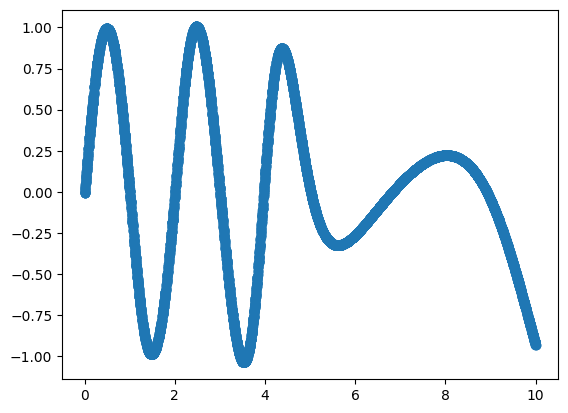

In [10]:
with torch.no_grad():
    pred_y = traj_model(train_x)
plt.scatter(train_x,pred_y)

In [2]:
ctrl = controller.controller()

In [3]:
Q = np.array(
    [
        [0,0,0,0],
        [0,30.,0,0],
        [0,0,0.,0],
        [0,0,0,1]
    ]
)

#R constructed by scale factor?
R = 1.*np.eye(2) 
'''R = np.array([
    [1/2,0],[0,1/(0.2)]
])'''
F = Q 

ctrl.set_cost(Q,R,F)

In [4]:
CL = 4.5
ctrl.dt = 0.02
ctrl.pred_horizon = 60
ctrl.control_horizon = 1
''' 
x: x,y,theta,v 
u: T,delta

'''
def f(x,u):
    return np.array([
        [(np.cos(x[2])*x[3])[0]],
        [(np.sin(x[2])*x[3])[0]],
        [((np.tan(u[1])/CL)*x[3])[0]],
        [(0.5*u[0])[0]]
    ])

def matrix_iterator(x0,u0):
    A = np.array([
        [0,    0,  (-np.sin(x0[2])*x0[3])[0],   (np.cos(x0[2]))[0]],
        [0,    0,  (np.cos(x0[2])*x0[3])[0],    (np.sin(x0[2]))[0]],
        [0,    0,  0,                      (np.tan(u0[1])/CL)[0]],
        [0,0,0,0]
    ]
    )

    B = np.array(
        [
        [0,0],
        [0,0],
        [0, (x0[3]/(np.cos(u0[1])**2 * CL))[0]],
        [0.5,0]
        ]
    )

    '''f0 = np.array([
        [(np.cos(x0[2])*x0[3])[0]],
        [(np.sin(x0[2])*x0[3])[0]],
        [((np.tan(u0[1])/CL)*x0[3])[0]],
        [(0.5*u0[0])[0]]
    ])'''
    f0 = f(x0,u0)

    return A,B,f0

x0 = np.array(
    [
        [0],
        [3.],
        [0],
        [20]
    ]
)

xd = np.array(
    [
        [0],
        [0.],
        [0],
        [20]
    ]
)

u0 = np.array(
    [
        [0],
        [0]
    ]
)


In [5]:
#Throttle: -0.2*dt ~ 0.2*dt
A1 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A1[i,2*i] = 1.
    #A1[i,2*i+1] = 1.
b1 = np.zeros([ctrl.pred_horizon,1]) - 0.2*ctrl.dt

A2 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A2[i,2*i] = -1.
    #A2[i,2*i+1] = -1.
b2 = np.zeros([ctrl.pred_horizon,1]) - 0.2*ctrl.dt

#Steering: -pi/30 * dt ~ pi/30 * dt
A3 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A3[i,2*i+1] = 1.
b3 = np.zeros([ctrl.pred_horizon,1]) - np.pi/30 * ctrl.dt

A4 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A4[i,2*i+1] = -1.
b4 = np.zeros([ctrl.pred_horizon,1]) - np.pi/30 * ctrl.dt


A_const = np.vstack([A1,A2,A3,A4])
b_const = np.vstack([b1,b2,b3,b4]).reshape(-1)
print(A_const.shape,b_const.shape)

(240, 120) (240,)


In [6]:

xlist = [x0]
ulist = [u0]
ctrl.setup_model(f)
ctrl.setup_constraints(A_const,b_const)

u_pile = np.tile(u0,(ctrl.pred_horizon,1))
for i in range(300):
    A,B,f0 = matrix_iterator(x0,u0)
    ctrl.update_dynamics(A,x0,B,u0,f0)
    ctrl.discretize(ctrl.dt)

    x0 = ctrl.apply_control(x0,u0) 
    xlist.append(x0)
    ctrl.setup_qp_linear(x0,u0,xd)
    u = ctrl.solve_qp()
    u0 = u[0:2].reshape(-1,1)
    for j in range(ctrl.control_horizon-1):
        ulist.append(u0)
        x0 = ctrl.apply_control(x0,u0) 
        xlist.append(x0)
        u0 = u[j*2+2:j*2+4].reshape(-1,1)
    
    ulist.append(u0)
    #print('stepped')


In [7]:
import matplotlib.pyplot as plt

In [8]:
xm = np.array(xlist).squeeze(-1)
print(xm.shape)

(1201, 4)


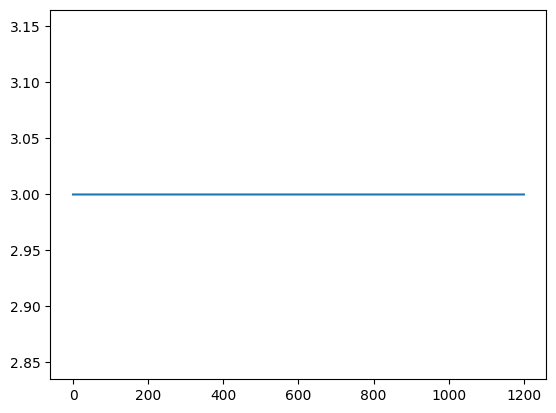

In [9]:
plt.plot(xm[:,1])

In [10]:
u_tilde = np.array(ulist).reshape(-1,2)

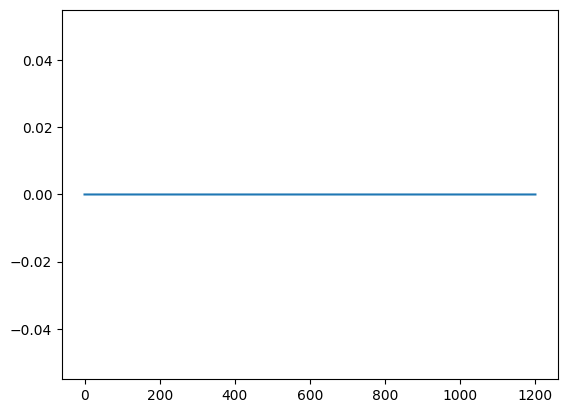

In [11]:
plt.plot(u_tilde[:,0])

In [12]:
u_tilde[6,0]

0.0